In [1]:
#@title
# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

1.8.0+cu101
10.1
Python 3.7.10
Wed Mar 17 17:29:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                         

In [2]:
#@title
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [3]:
# If this breaks, you might want to change the CUDA version displayed above (make sure the Pytorch version installed matches the installs here)
 
# Torch should already be installed
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.6MB 12.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 19.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 33.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 21.4MB/s 
     |████████████████████████████████| 194kB 20.3MB/s 
     |████████████████████████████████| 235kB 46.2MB/s 
     |████████████████████████████████| 2.2MB 33.4MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp37-none-any.whl size=322719 sha256=3fa8d8495281f9fb253b709b998a76cdfee2c2edfaa7548500adf4ec73b9af4c
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011

In [4]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [5]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[110])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  1
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(edge_attr=[22, 3], edge_index=[2, 22], smiles="Oc1c(I)cc(C#N)cc1I", x=[11, 9], y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [6]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [7]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].num_features

9

CC(C)=CCCC(C)=CC(=O)


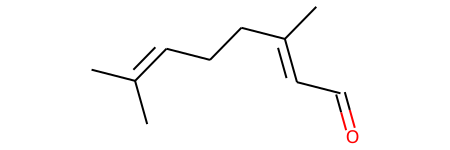

In [8]:
# plot one molecule from the database using rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[2]["smiles"])
print(data[2]["smiles"])
molecule

In [9]:
# Data Preparation for autoencoder
#creat a list that contains all the character in the database
import numpy as np
from sklearn.preprocessing import OneHotEncoder
allCharacter = []
lengthOfSmiles = []
for i in range(data.len()):
  allCharacter.extend(list(data[i].smiles.strip()))
  lengthOfSmiles.append(len(list(data[i].smiles.strip()))) 

TypeOfCharacter_noE = np.unique(allCharacter)
TypeOfCharacter = np.append(TypeOfCharacter_noE,['E'])
print(TypeOfCharacter)
print(max(lengthOfSmiles),min(lengthOfSmiles), sum(lengthOfSmiles)/len(lengthOfSmiles))
print(lengthOfSmiles.index(97))
print(data[934].smiles)


['#' '(' ')' '/' '1' '2' '3' '4' '5' '6' '7' '8' '=' 'B' 'C' 'F' 'H' 'I'
 'N' 'O' 'P' 'S' '[' '\\' ']' 'c' 'l' 'n' 'o' 'r' 's' 'E']
97 1 22.32712765957447
555
C


In [8]:
# Convert character to one hot encoding 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
One_Hot_Enc = OneHotEncoder(sparse=False)
X = np.array(TypeOfCharacter).reshape(TypeOfCharacter.shape[0],1)
One_Hot_Enc.fit(X)

test = One_Hot_Enc.transform(np.array([['#']]))
print(test.shape)
One_Hot_Enc.inverse_transform(np.zeros((1,TypeOfCharacter.shape[0])))


(1, 32)


array([['#']], dtype='<U1')

In [9]:
# Obtain the matrix size for autoencoder
NumCharac = len(TypeOfCharacter)
MaxLength = max(lengthOfSmiles)+1
print(NumCharac)
print(MaxLength)

32
98


In [10]:
def SmileToOneHot(smiles):
  """Input: smiles:a string of smile file
     Output: max length of a smile file * Number of characters used in the smiles database in that database array + E in the end
  """
  OneSmile = list(smiles.strip()+'E')
  OneSmileArray = np.zeros((MaxLength,NumCharac))
  for j in range(len(OneSmile)):
    OneLetter = np.reshape(OneSmile[j],(-1,1))
    OneLetterArray = One_Hot_Enc.transform(OneLetter).reshape(TypeOfCharacter.shape[0])
    OneSmileArray[j,:] = OneLetterArray
  return OneSmileArray

In [11]:
def OneHotToSmile(OneSmileArray):
  '''Input: a smile array of dimension Number of characters used in the smiles database * max length of a smile file
     Output: a string of smile
  '''
  BackToSmile = ''
  for k in range(OneSmileArray.shape[0]):
    BackToSmile += One_Hot_Enc.inverse_transform(OneSmileArray[k,:].reshape(1,-1)).item()
  index = BackToSmile.find('##') 
  BackToSmile = BackToSmile[:index]
  for (index,letter) in enumerate(BackToSmile):
    if letter =='E':
      BackToSmile = BackToSmile[:index]
      break
  
  return BackToSmile

In [12]:
# test whether one hot encode/ transform works or not 
testArray=SmileToOneHot(data[0].smiles)
smiles = OneHotToSmile(testArray)
print(data[0].smiles)
print(smiles)

OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O


In [ ]:
# Visualize one hot encoding for one molecule
np.set_printoptions(threshold=np.inf)
print(SmileToOneHot(data[2]["smiles"]))
np.set_printoptions(threshold=1000)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 

In [ ]:
#Prepare data for LSTM by labelling 
#Create unique, numerical labels for each character between 0 and n-1, where n is the number of unique characters
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(TypeOfCharacter_noE)
print("Array of labels for each character:")
print(integer_encoded)
label_encoder.transform(["#",'C'])
label_encoder.inverse_transform([0,14])

Array of labels for each character:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


array(['#', 'C'], dtype='<U1')

In [15]:
#Generate my own one hot encoding dataset for Autoencoder
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import torchvision.datasets as datasets
batch_size = 64

my_x = []
for i in range(data.len()):
  iSmileArray = SmileToOneHot(data[i].smiles)
  my_x.append(iSmileArray)
my_y = [np.array([data[i].y])for i in range(data.len())]
tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)
my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset

# define training set and testing set
train_size = int(round(len(my_x)*0.8))
test_size = len(my_dataset) - train_size
print(train_size)
train_dataset, test_dataset = random_split(my_dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=3, pin_memory=True)

NameError: ignored

In [16]:
# AutoEncoder
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
gpu_id = 0
device = torch.device("cuda:%d" % (gpu_id) if torch.cuda.is_available() else "cpu")
import copy

class autoencoder(nn.Module):
    def __init__(self):

        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(98*32, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 98*32),
            nn.ReLU())

    def forward(self, x):
      x = x.view(x.shape[0],-1)
      x = self.encoder(x)
      x = self.decoder(x)
      return x


net = autoencoder().to(device)
print(net)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3136, bias=True)
    (3): ReLU()
  )
)


In [ ]:
# Training for autoencoder
import time
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
iterations = 2000
BatchSize = 64
with open ('/content/drive/MyDrive/GoogleColab/loss_time.csv','w') as outfile:
  outfile.write('Iteration,loss,time\n')
  for epoch in range(iterations):
    torch.cuda.synchronize()
    since = int(round(time.time()*1000))
    runningLoss = 0
    for train_num, (SmileArray, solubility) in enumerate(trainloader):
      SmileArray =SmileArray.to(device = device)       
      optimizer.zero_grad()
      outputs = net(SmileArray)
      loss = criterion(outputs, SmileArray.view(-1,98*32))
      loss.backward()
      optimizer.step()
      runningLoss += loss.item()
    torch.cuda.synchronize()
    time_elapsed = int(round(time.time()*1000)) - since
    outfile.write(f'{epoch+1},{runningLoss/BatchSize},{time_elapsed}\n')
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finished Training


In [ ]:
# check whether the generated string is the same as the input and whether it's a valid smile string 
def check_accuracy(loader,model,fileName):
  '''output a file with real smile string, predicted smile string, real smile (1 for real, 0 for fake), a match (1 for a match, 0 for not a match ) '''
  with open(f'/content/drive/MyDrive/GoogleColab/{fileName}.csv','w') as outfile:
    outfile.write('Real,predicted,real smile, match\n')
    num_correct = 0
    num_smile = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():        
        for x,y in loader:
            x = x.to(device = device)
            SmileArray = model(x)
            SmileArray = SmileArray.view(-1,98,32)
            for i in range(SmileArray.shape[0]):
              SmileOneHotArray = torch.zeros_like(SmileArray[i])
              predictions,index = SmileArray[i].max(1)
              n_row = 0
              for j in index:
                SmileOneHotArray[n_row][j]=1
                n_row+=1
              SmileString = OneHotToSmile(SmileOneHotArray.cpu())
              realSmileString = OneHotToSmile(x[i].cpu())
              m = Chem.MolFromSmiles(SmileString)
              if SmileString == realSmileString:
                num_correct +=1
                outfile.write(f'{realSmileString},{SmileString},1,1\n')
                print(f'{realSmileString},{SmileString},1,1\n')
              elif m!= None:
                num_smile+=1
                outfile.write(f'{realSmileString},{SmileString},1,0\n')
                print(f'{realSmileString},{SmileString},1,0\n')
              else:
                outfile.write(f'{realSmileString},{SmileString},0,0\n')             
              num_samples +=1               
        acc = float(num_correct)/float(num_samples)
    print(f"Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    print(f"Number of smile {num_smile} with a chance of {float(num_smile)/float(num_samples)*100:.2f}")
    model.train()
  return acc

In [12]:
# save model in google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
torch.save(net.state_dict(), "/content/drive/MyDrive/GoogleColab/AutoEncoder")


NameError: ignored

In [17]:
# reload model from google drive
model = autoencoder().to(device = device)
model.load_state_dict(torch.load("/content/drive/MyDrive/GoogleColab/AutoEncoder",map_location=device))
model.eval()

NameError: ignored

In [ ]:
# Testing 
check_accuracy(trainloader,model,'train')
check_accuracy(testloader,model,'test')





In [ ]:
check_accuracy(trainloader,net)
check_accuracy(testloader,net)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Got 95/902 with accuracy 10.53
Number of smile 103 with a chance of 11.42


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Got 17/226 with accuracy 7.52
Number of smile 30 with a chance of 13.27


0.0752212389380531

In [ ]:
# separate encoder and decoder
encoder = nn.Sequential(*list(model.children())[:-1])
decoder = nn.Sequential(*list(model.children())[1:])
encoder

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3136, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
)

In [ ]:
# Check the ouput of encoder
iterations = 1
with torch.no_grad():

  for epoch in range(iterations):
      for train_num, (SmileArray, solubility) in enumerate(trainloader):
        SmileArray =SmileArray.to(device = device)
        outputs = encoder(SmileArray.view(SmileArray.shape[0],-1))
        break


print(outputs[0])
# outputs seems to be from 0 to 1 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1.4916e+00, 2.9923e+00, 2.7978e+00, 6.6497e-01, 3.2855e+00, 2.0129e+00,
        2.1819e+00, 2.5681e+00, 1.7372e+00, 2.1326e+00, 2.0308e+00, 2.2864e+00,
        1.4178e+00, 1.6438e+00, 1.9863e+00, 2.6837e+00, 1.1686e+00, 0.0000e+00,
        1.0308e+00, 3.4281e+00, 1.8885e+00, 1.7087e+00, 1.8589e+00, 2.2879e+00,
        3.7759e+00, 3.1836e+00, 2.4989e+00, 2.9967e+00, 2.1099e+00, 1.9115e+00,
        1.4001e+00, 6.0013e-02, 2.0257e-04, 3.2717e+00, 1.8725e+00, 4.7441e-01,
        0.0000e+00, 1.0125e+00, 0.0000e+00, 3.7120e+00, 1.8445e+00, 1.3258e+00,
        2.4842e+00, 1.2921e+00, 4.1484e+00, 1.9901e+00, 0.0000e+00, 1.0086e+00,
        1.8405e+00, 1.7778e+00, 8.9723e-01, 0.0000e+00, 2.9534e+00, 2.3616e+00,
        9.2669e-01, 1.2768e+00, 1.5856e+00, 1.8398e+00, 1.1465e+00, 7.2678e-03,
        1.9085e-01, 0.0000e+00, 1.0504e+00, 2.2805e+00, 1.4510e+00, 0.0000e+00,
        1.1364e+00, 2.3614e+00, 3.7164e+00, 1.8887e+00, 3.1749e+00, 0.0000e+00,
        0.0000e+00, 3.0298e-01, 0.0000e+

In [ ]:
#Generate random input of dimension batchsize*100 from 0 to 1
num_random_mole = 900
randomInput = torch.rand(num_random_mole, 100)
randomInput = randomInput.to(device = device)

In [ ]:
# check for smile if it's a valid smile, denote it with 1
num_smile = 0
with torch.no_grad():
  outputs = decoder(randomInput)

with open('/content/drive/MyDrive/GoogleColab/Generated_Smile.csv','w') as outfile:
  outfile.write('Generated_Smile,Real\n')

  for i in range(num_random_mole):
    OneSmile = outputs[i].view(98,32)
    OneSmileString = OneHotToSmile(OneSmile.cpu())
    m = Chem.MolFromSmiles(OneSmileString)
    if m != None:
      num_smile+=1
      outfile.write(f'{OneSmileString},1\n')
    else:
      outfile.write(f'{OneSmileString},0\n')


print(num_smile,num_smile/num_random_mole)



89 0.09888888888888889


In [31]:
# LSTM model 
! pip install unidecode
import torch
import torch.nn as nn
import string
import random
import sys
import unidecode

     |████████████████████████████████| 245kB 19.1MB/s 


In [11]:
# Get characters from string.printable
all_characters = string.printable
n_characters = len(all_characters)
all_characters

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [23]:
#Create a training and testing text file with all the smiles
with open('/content/drive/MyDrive/GoogleColab/smile_training.txt','w') as outfile:
  for i in range(int(round(data.len())*0.8)):
    outfile.write(f"{data[i].smiles}\n")

with open('/content/drive/MyDrive/GoogleColab/smile_testing.txt','w') as outfile:
  for i in range(int(round(data.len())*0.8),data.len()):
    outfile.write(f"{data[i].smiles}\n")

In [137]:
# Read large text file (Note can be any text file: not limited to just names)
file = unidecode.unidecode(open("/content/drive/MyDrive/GoogleColab/smile_testing.txt").read())
file

'COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C\nCCOC(=O)CC\nCSc1nc(NC(C)C)nc(NC(C)C)n1\nCC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1\nCc1cc2ccccc2cc1C\nClc1ccc(cc1)c2cc(Cl)ccc2Cl \nClc1ccc(c(Cl)c1)c2cc(Cl)c(Cl)c(Cl)c2Cl \nNC(N)=NC#N \nClC(Cl)(Cl)N(=O)=O\nClc1cccc(Cl)c1c2ccccc2 \nCOc1ccc(C=O)cc1\nCC(=O)Nc1ccc(cc1)N(=O)=O\nCCCCCCC(=O)OCC\nCC(=O)Nc1ccc(O)cc1\nc2ccc1[nH]ncc1c2 \nCC5(C)OC4CC3C2CCC1=CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O5)C(=O)CO \nNc2nc1[nH]cnc1c(=O)[nH]2 \nCOC(=O)C\nCC34CCC1C(CCC2CC(=O)CCC12C)C3CCC4O \nCCCC(O)C=C\nOC(C1=CC2C5C(C1C2=C(c3ccccc3)c4ccccn4)C(=O)NC5=O)(c6ccccc6)c7ccccn7 \nCCCCOCCCC\nCCCCCCCCCCCCO\nCCN2c1nc(N(C)(CCO))ccc1NC(=O)c3cccnc23 \nCCCC(C)(C)O\nNc1nc(=O)[nH]cc1F\nCCCCOc1ccc(C(=O)OCC)c(c1)N(CC)CC \nCCCCCC(C)(C)O\nCc1c(C)c(C)c(C)c(C)c1C\nCC(C)c1ccc(C)cc1O\nc2cnc1ncncc1n2\nCCOP(=S)(OCC)Oc1ccc(cc1)N(=O)=O\nC\nc2ccc1NCCc1c2 \nO=N(=O)c1cccc2ccccc12\nCCC(C)C(=O)C\nNc1nc(O)nc2nc[nH]c12 \nOC(CC(c1ccccc1)c3c(O)c2ccccc2oc3=O)c4ccc(cc4)c5ccc(Br)cc5 \nCN(=O)=O\nCC(C)N(C(C)C)C(=O)SCC(Cl)=C(Cl)Cl\n

In [12]:
# RNN model 
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        out = self.embed(x)
        out, (hidden, cell) = self.lstm(out.unsqueeze(1), (hidden, cell))
        out = self.fc(out.reshape(out.shape[0], -1))
        return out, (hidden, cell)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [62]:
# record loss function
import time
class Generator:
    def __init__(self):
        self.chunk_len = 250
        self.num_epochs = 5000
        self.batch_size = 1
        self.print_every = 50
        self.hidden_size = 256
        self.num_layers = 2
        self.lr = 0.003
        self.rnn = RNN(n_characters, self.hidden_size, self.num_layers, n_characters).to(device)
        self.temperature = 0.5
    


    def char_tensor(self, string):
        tensor = torch.zeros(len(string)).long()
        for c in range(len(string)):
            tensor[c] = all_characters.index(string[c])
        return tensor

    def get_random_batch(self):
        start_idx = random.randint(0, len(file) - self.chunk_len)
        end_idx = start_idx + self.chunk_len + 1
        text_str = file[start_idx:end_idx]
        text_input = torch.zeros(self.batch_size, self.chunk_len)
        text_target = torch.zeros(self.batch_size, self.chunk_len)

        for i in range(self.batch_size):
            text_input[i, :] = self.char_tensor(text_str[:-1])
            text_target[i, :] = self.char_tensor(text_str[1:])

        return text_input.long(), text_target.long()

    def generate(self, initial_str="C", predict_len=100):

        hidden, cell = self.rnn.init_hidden(batch_size=self.batch_size)
        initial_input = self.char_tensor(initial_str)
        predicted = initial_str

        for p in range(len(initial_str) - 1):
            _, (hidden, cell) = self.rnn(
                initial_input[p].view(1).to(device), hidden, cell
            )

        last_char = initial_input[-1]

        for p in range(predict_len):
            output, (hidden, cell) = self.rnn(
                last_char.view(1).to(device), hidden, cell
            )
            output_dist = output.data.view(-1).div(self.temperature).exp()
            top_char = torch.multinomial(output_dist, 1)[0]
            predicted_char = all_characters[top_char]
            predicted += predicted_char
            last_char = self.char_tensor(predicted_char)

        return predicted

    # input_size, hidden_size, num_layers, output_size
    def train(self):
      torch.cuda.synchronize()
      since = int(round(time.time()*1000))

      optimizer = torch.optim.Adam(self.rnn.parameters(), lr=self.lr)
      criterion = nn.CrossEntropyLoss()
#       writer = SummaryWriter(f"runs/names0")  # for tensorboard

      print("=> Starting training")
      with open('/content/drive/MyDrive/GoogleColab/LSTM_training_Loss_time_1000.csv','w') as outfile:
        outfile.write('epoch,loss,time\n')
        for epoch in range(1, self.num_epochs + 1):

          inp, target = self.get_random_batch()
          hidden, cell = self.rnn.init_hidden(batch_size=self.batch_size)

          self.rnn.zero_grad()
          loss = 0
          inp = inp.to(device)
          target = target.to(device)

          for c in range(self.chunk_len):
              output, (hidden, cell) = self.rnn(inp[:, c], hidden, cell)
              loss += criterion(output, target[:, c])

          loss.backward()
          optimizer.step()
          loss = loss.item() / self.chunk_len
          torch.cuda.synchronize()
          time_elapsed = int(round(time.time()*1000)) - since
          outfile.write(f'{epoch},{loss},{time_elapsed}\n')

        # if epoch % self.print_every == 0:
        #     print(f"Loss: {loss}")
        #     print(self.generate())


    def check_accuracy(self):
      with torch.no_grad():
        Num_Accurate = 0
        for epoch in range(1, 50 + 1):
            inp, target = self.get_random_batch()
            hidden, cell = self.rnn.init_hidden(batch_size=self.batch_size)
            inp = inp.to(device)
            target = target.to(device)
            for c in range(self.chunk_len):
              output, (hidden, cell) = self.rnn(inp[:, c], hidden, cell)
              biggest_index = output.argmax(1)
              if biggest_index == target[:,c]:
                Num_Accurate+=1
        print(Num_Accurate/(50*self.chunk_len))



 #           writer.add_scalar("Training loss", loss, global_step=epoch)


#gennames = Generator()
#gennames.train()

In [14]:
#saving the training data on google drive
torch.save(gennames.rnn.state_dict(), "/content/drive/MyDrive/GoogleColab/Generator")

NameError: ignored

In [63]:
# how to load it back
model = Generator()
model.rnn.load_state_dict(torch.load("/content/drive/MyDrive/GoogleColab/Generator"))
model.rnn.eval()

RNN(
  (embed): Embedding(100, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=100, bias=True)
)

In [56]:
model.temperature

0.1

In [138]:
# check the accuracy of either the training or the testing data
gennames.check_accuracy()

0.67336


In [64]:
# record the data generate by the model
with open('/content/drive/MyDrive/GoogleColab/LSTMSmile_0.5.txt','w') as outfile:
  for i in range(200):
    outfile.write(f'{model.generate()[1:]}')
model.generate()

'CCC(C)(C)O\nO=C2NC(=O)C1(CCCCCC1)C(=O)N2\nCC(C)C1CCC(C)C1CCC3C2CCC1=CC(=O)C=CC1(C)C2(F)C(O)CC34C)C(=O)O'

In [65]:
# Check how many smiles are valid smiles
num_smile = 0
with open('/content/drive/MyDrive/GoogleColab/LSTMSmile_0.5.txt','r') as infile:
  with open('/content/drive/MyDrive/GoogleColab/LSTMRealSmile_0.5.txt','w') as outfile:
    lines = infile.readlines()
    for aline in lines:
      asmile = aline.strip()
      m = Chem.MolFromSmiles(asmile)
      if m != None and asmile !='' :
        outfile.write(aline)
        num_smile+=1

print(f'number of smiles: {num_smile}, number of total string: {len(lines)}, {num_smile/len(lines)}')

number of smiles: 658, number of total string: 868, 0.7580645161290323


In [ ]:
# check for overlap between the training and the generating using PCA
import torch
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

x = torch.tensor([[1,2,3],[4,5,6],[7,8,9],[7,8,9]])
principalComponents = pca.fit_transform(x)


array([[ 6.49519053e+00,  3.41647519e-16],
       [ 1.29903811e+00, -6.12811374e-17],
       [-3.89711432e+00,  2.74492743e-16],
       [-3.89711432e+00,  2.74492743e-16]])

In [73]:
# check similarity
with open("/content/drive/MyDrive/GoogleColab/smile.txt",'r') as training, open("/content/drive/MyDrive/GoogleColab/LSTMRealSmile_0.95.txt",'r') as outfile, open("/content/drive/MyDrive/GoogleColab/LSTMNewSmile_0.95.txt",'w') as writefile:
  max_char = 0
  train = training.readlines()
  out = outfile.readlines()
  train_set = set(train)
  out_set = set(out)
  same_num = len(out)-len(out_set)
  overlap_num = len(train_set.intersection(out_set))
  new = out_set-train_set
  for anew in new:
    writefile.write(anew)
  for aline in train:
    length = len(aline.strip())
    if length > max_char:
      max_char = length
  for aline in out:
    length = len(aline.strip())
    if length > max_char:
      max_char = length
  print(f"out of {len(out)}, {same_num} duplicate, {overlap_num} overlap, {len(new)} new, {max_char} max")

out of 550, 138 duplicate, 225 overlap, 187 new, 97 max


In [143]:
# principle component analysis 

training_tensor = torch.zeros((len(train),max_char)).long()
out_tensor = torch.zeros((len(out),max_char)).long()
for i in range(len(train)):
  training_tensor[i,:len(train[i].strip())]=Generator().char_tensor(string = train[i].strip())
for i in range(len(out)):
  out_tensor[i,:len(out[i].strip())] = Generator().char_tensor(string = out[i].strip())


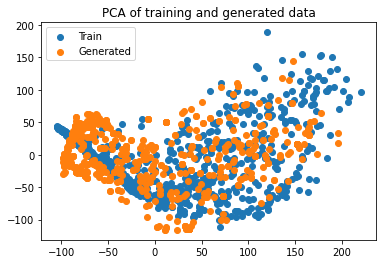

In [144]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents_training = pca.fit_transform(training_tensor)
principalComponents_out = pca.fit_transform(out_tensor)

plt.scatter(principalComponents_training[:,0],principalComponents_training[:,1],label = 'Train')
plt.scatter(principalComponents_out[:,0],principalComponents_out[:,1], label = 'Generated')
plt.legend()
plt.title('PCA of training and generated data')
plt.savefig('/content/drive/MyDrive/GoogleColab/PCA.png')



TypeError: ignored

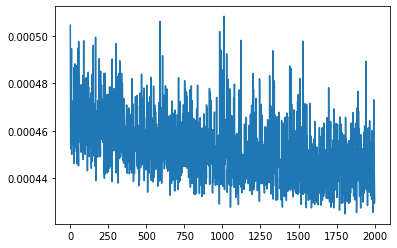

In [ ]:
# Plotting loss and time for Autoencoder
import pandas as pd
import matplotlib.pyplot as plt
name="/content/drive/MyDrive/GoogleColab/loss_time.csv"
data = pd.read_csv(name)
fig, ax = plt.subplots()
x=data['Iteration']
y=data['loss']
z = data['time']
plt.plot(x,y)
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.title("AutoEncoder Loss")
plt.savefig('/content/drive/MyDrive/GoogleColab/AutoEncoderLoss.jpg')
ztotal = [sum(z[:i]) for i in range(len(z))]

print(sum(z)/len(z))


In [ ]:
plt.plot(x,ztotal)
plt.title("AutoEncoder Time")
plt.xlabel("Epoches")
plt.ylabel("Time")
plt.savefig('/content/drive/MyDrive/GoogleColab/AutoEncoderTime.jpg')

NameError: ignored

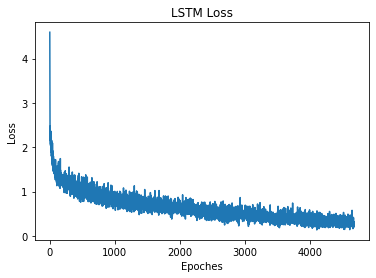

In [ ]:
# Plotting loss and time for LSTM
import pandas as pd
import matplotlib.pyplot as plt
name="/content/drive/MyDrive/GoogleColab/LSTM_Loss_time.csv"
data = pd.read_csv(name)
fig, ax = plt.subplots()
x=data['epoch']
y=data['loss']
z = data['time']
plt.plot(x,y)
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.title("LSTM Loss")
plt.savefig('/content/drive/MyDrive/GoogleColab/LSTM_Loss.jpg')




In [ ]:
plt.plot(x,z)
plt.title("LSTM Time")
plt.xlabel("Epoches")
plt.ylabel("Time")
plt.savefig('/content/drive/MyDrive/GoogleColab/LSTM_Time.jpg')

NameError: ignored

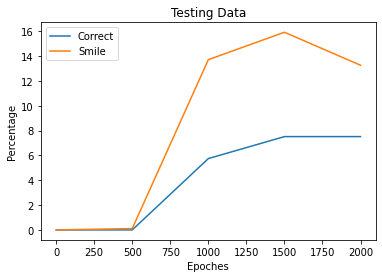

In [ ]:
# Plotting validation for Autoencoder
epochs = [0,500,1000,1500,2000]
correct_training = [0,0,7.21,10.2,10.53]
smile_training = [0,0.89,10.09,11.53,11.42]
correct_testing = [0,0,5.75,7.52,7.52]
smile_testing = [0,0.11,13.72,15.93,13.27]
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.plot(epochs,correct_testing,label = 'Correct')
plt.plot(epochs,smile_testing,label = 'Smile')
plt.legend()
plt.title('Testing Data')
plt.savefig("/content/drive/MyDrive/GoogleColab/AutoencoderTesting.png")

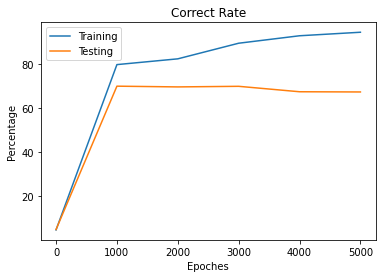

In [145]:
# Ploting Validation for LSTM
epochs = [0,1000,2000,3000,4000,5000]
correct_training = [4.632,79.768,82.392,89.488,92.88,94.48]

correct_testing = [4.808,69.968,69.632,69.904,67.432,67.336]

plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.plot(epochs,correct_training,label = 'Training')
plt.plot(epochs,correct_testing,label = 'Testing')
plt.legend()
plt.title('Correct Rate')
plt.savefig("/content/drive/MyDrive/GoogleColab/LSTM_correct.png")

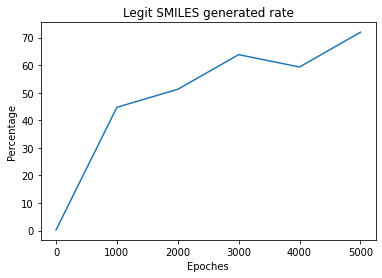

In [147]:
epochs = [0,1000,2000,3000,4000,5000]
smiles = [0.255,44.728,51.25,63.814,59.33, 71.94]
plt.xlabel("Epochs")
plt.ylabel("Percentage")

plt.plot(epochs,smiles)

plt.title('Legit SMILES generated rate')
plt.savefig("/content/drive/MyDrive/GoogleColab/LSTM_smile.png")

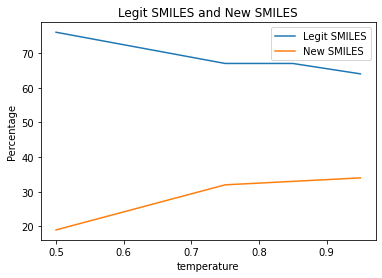

In [74]:
temperature = [0.5,0.75,0.85,0.95]
LegitSmiles = [76,67,67,64]
NewSmiles = [19,32,33,34]
plt.xlabel("temperature")
plt.ylabel("Percentage")

plt.plot(temperature,LegitSmiles,label = 'Legit SMILES')
plt.plot(temperature,NewSmiles,label = 'New SMILES')
plt.legend()
plt.title('Legit SMILES and New SMILES')
plt.savefig("/content/drive/MyDrive/GoogleColab/LSTM_temperature.png")

In [66]:
# Data Preparation for autoencoder without padding
# The results without padding is as bad as with padding so it's not further investigated
#creat a list that contains all the character in the database
import numpy as np
from sklearn.preprocessing import OneHotEncoder
allCharacter = []
lengthOfSmiles = []
for i in range(data.len()):
  allCharacter.extend(list(data[i].smiles.strip()))
  lengthOfSmiles.append(len(list(data[i].smiles.strip()))) 

TypeOfCharacter_noE = np.unique(allCharacter)
TypeOfCharacter = np.append(TypeOfCharacter_noE,['\n'])
print(TypeOfCharacter)
print(max(lengthOfSmiles),min(lengthOfSmiles), sum(lengthOfSmiles)/len(lengthOfSmiles))
print(lengthOfSmiles.index(97))
print(data[934].smiles)

# Convert character to one hot encoding 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
One_Hot_Enc = OneHotEncoder(sparse=False)
X = np.array(TypeOfCharacter).reshape(TypeOfCharacter.shape[0],1)
One_Hot_Enc.fit(X)

test = One_Hot_Enc.transform(np.array([['C']]))
print(test)
One_Hot_Enc.inverse_transform(np.zeros((3,TypeOfCharacter.shape[0])))
with open('test.txt','w') as outfile:
  for item in One_Hot_Enc.inverse_transform(np.zeros((3,TypeOfCharacter.shape[0]))):
    outfile.write(item.item())
  



['#' '(' ')' '/' '1' '2' '3' '4' '5' '6' '7' '8' '=' 'B' 'C' 'F' 'H' 'I'
 'N' 'O' 'P' 'S' '[' '\\' ']' 'c' 'l' 'n' 'o' 'r' 's' '\n']
97 1 22.32712765957447
555
C
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [67]:
training_data =[]
with open('/content/drive/MyDrive/GoogleColab/smile_training.txt','r') as infile:
  lines = infile.readlines()
  onehotlistTraining = []
  One_Hot_Enc_n = One_Hot_Enc.transform(np.array([['\n']]))
  for aline in lines:
    aline = aline.strip()
    for char in aline:
      alineOneHot = One_Hot_Enc.transform(np.array([[char]]))
      onehotlistTraining.append(alineOneHot)

    onehotlistTraining.append(One_Hot_Enc_n)

print(len(onehotlistTraining))

    



21051


In [68]:
import random
import torch
chunk_length = 250

def input_generator(chunk_length):
  start_ind = random.randint(0, len(onehotlistTraining) - chunk_length)
  input = onehotlistTraining[start_ind:start_ind+chunk_length]
  return torch.tensor(input)

In [69]:
input_test = input_generator(chunk_length)
input_test.shape

torch.Size([250, 1, 32])

In [70]:
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
gpu_id = 0
device = torch.device("cuda:%d" % (gpu_id) if torch.cuda.is_available() else "cpu")
import copy


class autoencoder_no_padding(nn.Module):
    def __init__(self):

        super(autoencoder_no_padding, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(chunk_length*32, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, chunk_length*32),
            nn.ReLU())

    def forward(self, x):
      x = x.view(1,-1)
      x = self.encoder(x)
      x = self.decoder(x)
      return x


net_no_padding = autoencoder_no_padding().to(device)
print(net_no_padding)

init_weights = copy.deepcopy(net_no_padding.encoder[0].weight.data)

autoencoder_no_padding(
  (encoder): Sequential(
    (0): Linear(in_features=8000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=8000, bias=True)
    (3): ReLU()
  )
)


In [78]:
# Training for autoencoder
import time
criterion = nn.MSELoss()
optimizer = optim.SGD(net_no_padding.parameters(), lr=0.5, momentum=0.9)
iterations = 1000000
BatchSize = 64
with open ('/content/drive/MyDrive/GoogleColab/loss_time_no_padding.txt','w') as outfile:

  since = int(round(time.time()*1000))

  for epoch in range(iterations):
    torch.cuda.synchronize()
    input = input_generator(chunk_length)
    input = input.to(device = device)    
    optimizer.zero_grad()
    outputs = net_no_padding(input.float())
    loss = criterion(outputs, input.view(1,-1).float())
    loss.backward()
    optimizer.step()
    runningLoss = loss.item()
    torch.cuda.synchronize()
    time_elapsed = int(round(time.time()*1000)) - since
#    print(f'{epoch+1},{runningLoss},{time_elapsed}')
    outfile.write(f'{epoch+1},{runningLoss},{time_elapsed}\n')
print('Finished Training')

Finished Training


In [72]:
# separate encoder and decoder
encoder_no_padding = nn.Sequential(*list(net_no_padding.children())[:-1])
decoder_no_padding = nn.Sequential(*list(net_no_padding.children())[1:])
encoder_no_padding


Sequential(
  (0): Sequential(
    (0): Linear(in_features=8000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
)

In [53]:
# Check the ouput of encoder

with torch.no_grad():
  input = input_generator(chunk_length).to(device=device)
  outputs = net_no_padding(input.float())


# outputs seems to be from 0 to 1 

tensor(0., device='cuda:0')


In [79]:
#Generate random input of dimension batchsize*100 from 0 to 1
num_random_mole = 900
randomInput = torch.rand(num_random_mole, 100)
randomInput = randomInput.to(device = device)

In [80]:
# Generate new molecules
num_smile = 0
with torch.no_grad():
  outputs = decoder(randomInput)

with open('/content/drive/MyDrive/GoogleColab/Generated_Smile_No_Padding.txt','w') as outfile:

  for i in range(num_random_mole):
    OneSmile = outputs[i].view(250,32)
    OneSmileOneHot = torch.zeros_like(OneSmile)
    predictions,index = OneSmile.max(1)
    n_row = 0
    for j in index:
      OneSmileOneHot[n_row][j]=1
      n_row+=1
    Smiles = One_Hot_Enc.inverse_transform(OneSmileOneHot.cpu())
    for item in Smiles:
      outfile.write(item.item())






In [81]:
# Check how many smiles are valid smiles
num_smile = 0
with open('/content/drive/MyDrive/GoogleColab/Generated_Smile_No_Padding.txt','r') as infile:
  with open('/content/drive/MyDrive/GoogleColab/Generated_Real_Smile_No_Padding.txt','w') as outfile:
    lines = infile.readlines()
    for aline in lines:
      asmile = aline.strip()
      m = Chem.MolFromSmiles(asmile)
      if m != None and asmile !='' :
        outfile.write(aline)
        num_smile+=1

print(f'number of smiles: {num_smile}, number of total string: {len(lines)}, {num_smile/len(lines)}')

number of smiles: 45, number of total string: 5669, 0.007937907920268125


In [ ]:
features = 16
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var